In [0]:
# Image Stitching using Harris Corners and SIFT Descriptors

In [0]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import random


In [3]:
folder_id = '1nrXjo4X-E3vcRsZ3bd08tR4pv0RVSczh' # Enter the last part of the URL of the Google Drive folder here

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

title: keble_a.jpg, id: 1CaBnLZVKRV3r-IUQsKJMYDEyA83Naodn
downloading to /root/data/keble_a.jpg
title: keble_b.jpg, id: 1cpXG0rvlOGMCj4FbjXAUyw-HZAKDC4lJ
downloading to /root/data/keble_b.jpg
title: keble_c.jpg, id: 1dO_t5RzRUZQHk-QW0uaV6syjSdb27Zgb
downloading to /root/data/keble_c.jpg
title: sift_features.mat, id: 12P3qwZDIynt6G6h-qQwAiwrerZ0TGjGD
downloading to /root/data/sift_features.mat
title: corners.mat, id: 12gU_phqObqEcZ45SFtesVBbTBxcE4rzf
downloading to /root/data/corners.mat


In [0]:
# Input Images, Harris Corners & SIFT Descriptors

In [0]:
harris_corners= scipy.io.loadmat('corners.mat')
harris_corners_center = harris_corners['corners_center']
harris_corners_left = harris_corners['corners_left']
harris_corners_right = harris_corners['corners_right']

sift_desc = scipy.io.loadmat('sift_features.mat')
sift_desc_left = sift_desc['sift_left']
sift_desc_center = sift_desc['sift_center']
sift_desc_right = sift_desc['sift_right']


left_image = plt.imread('keble_a.jpg')
center_image = plt.imread('keble_b.jpg')
right_image = plt.imread('keble_c.jpg')


In [0]:
# Calulating Absolute Distance between SIFT Descriptors of Left with Center Image & Right with Center

In [0]:
sift_l2 = []
sift_l2_R = []
matched = []
mat_har = []
mat_har_center = []
mat_har2 = []
mat_har2_R = []

mat_har_R = []
dist1 = []
dist2 =[]
dist1_R = []
dist2_R =[]
dist1nn = np.zeros((200,1))
dist2nn = np.zeros((200,1))
harris_corners_left_2 = []
har1 = []
# Absolute Error calculation between Left<->Center & Right<->Center
for i in range(0,200):
  for j in range(0,200):
    sift_l2.append(np.sum(np.square(np.array(sift_desc_center[i,:])-np.array(sift_desc_left[j,:]))));
    sift_l2_R.append(np.sum(np.square(np.array(sift_desc_center[i,:])-np.array(sift_desc_right[j,:]))));

    
  l2 = np.array(sift_l2)
  l2_R = np.array(sift_l2_R)
  
  # Finding the First Neighbour and Second Neighbour, by taking first and second lowest distances
  l21 = np.argsort(l2)
  #print(l21[:10])
  l21_R = np.argsort(l2_R)
  #print(l21_R[:10])
  
  # Appending the corresponding left,center, and right points to empty lists
  mat_har.append(harris_corners_left[l21[0],:])
  mat_har_center.append(harris_corners_center[i,:])
  mat_har_R.append(harris_corners_right[l21_R[0],:])


  dist1.append(l2[l21[0]])
  
  dist1_R.append(l2_R[l21_R[0]])

  mat_har2.append(harris_corners_left[l21[1],:])
  mat_har2_R.append(harris_corners_right[l21_R[1],:])

  dist2.append(l2[l21[1]])
  dist2_R.append(l2_R[l21_R[1]])

  sift_l2 = []
  sift_l2_R = []
 
  

matched_features = np.array(matched)  
matched_harris = np.array(mat_har)
matched_harris_R = np.array(mat_har_R)

matched_harris_center = np.array(mat_har_center)

matched_harris2 = np.array(mat_har2)

dist1nn = np.array(dist1)
#print(dist1nn[:10])
dist2nn = np.array(dist2)
#print(dist2nn[:10])
dist1_Rnn = np.array(dist1_R)
dist2_Rnn = np.array(dist2_R)

In [0]:
# Performing Lowe's test to weed out bad features and get Good Matches Left<->Center & Right<->Center

In [9]:
g_feat = [];
g_feat_R=[];
g_feat2_R = [];
g_feat2 = []
for i in range(0,200):
  if (dist1nn[i] < 0.25*dist2nn[i]): # Comparing 1-NN and 2-NN distances between Left and Center matches
   
    g_feat.append(matched_harris[i])
    #print(g_feat)
    g_feat2.append(matched_harris_center[i])
    #print(g_feat2)

good_features = np.array(g_feat)
good_features_center = np.array(g_feat2)

for i in range(0,200):
  if (dist1_Rnn[i] < 0.19*dist2_Rnn[i]): # Comparing 1-NN and 2-NN distances between Right and Center matches
   
    g_feat_R.append(matched_harris_R[i])
    g_feat2_R.append(matched_harris_center[i])

good_features_R = np.array(g_feat_R)
good_features_center_R = np.array(g_feat2_R)


print(good_features.shape)
print(good_features_center_R.shape)


(22, 2)
(24, 2)


In [0]:
# Plot the Good Macthes

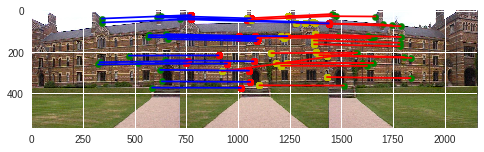

In [11]:
left_center_image = np.hstack((left_image,center_image,right_image))
width = left_image.shape[1]
plt.imshow(left_center_image)
for i in range(0,22):
  plt.plot([good_features[i,0], good_features_center[i,0]+width], [good_features[i,1],good_features_center[i,1] ],'b')
  plt.plot([good_features_R[i,0]+2*width, good_features_center_R[i,0]+width], [good_features_R[i,1],good_features_center_R[i,1] ],'r')
  plt.scatter(x=[good_features[i,0]], y=[good_features[i,1]], c='g', s=40)
  plt.scatter(x=[good_features_R[i,0]+2*width], y=[good_features_R[i,1]], c='g', s=40)
  plt.scatter(x=[good_features_center[:,0]+width], y=[good_features_center[:,1]], c='r', s=40)
  plt.scatter(x=[good_features_center_R[:,0]+width], y=[good_features_center_R[:,1]], c='y', s=40)


In [0]:
# Function to compute Homography, 'H' between im1_pts and im2_pts, x=HX' 

In [0]:
def computeH(im1_pts, im2_pts):

  A1 = np.zeros((1,9))
  A2 = np.zeros((1,9))
  A = np.zeros((2*4,9))
  size = len(im1_pts)
  i=0
  
  for i in range(0,size):
    A1 = np.hstack((-1*np.array(im1_pts[i,0]),-1*np.array(im1_pts[i,1]),-1,0,0,0, np.array(float(im2_pts[i,0])*im1_pts[i,0]),np.array(im2_pts[i,0]*im1_pts[i,1]),np.array(im2_pts[i,0])))
    A2 = np.hstack((0,0,0,float(-1*im1_pts[i,0]),-1*im1_pts[i,1],-1, float(im2_pts[i,1])*im1_pts[i,0],float(im2_pts[i,1]*im1_pts[i,1]),im2_pts[i,1]))
    if i<1:
      A = np.vstack((A1,A2))
    else:
        A = np.vstack((A,A1,A2))
      
  
  [U,S,V] = svd(A)
  V1 = np.transpose(V)
  
  H = V1[:,-1].reshape(3,3)
  
  H=H/H[2,2]
  
  return H


In [0]:
# Implementation of RANSAC Algorithm to give Robust set of Good Matches between images, ie, remove Outliers

In [0]:
#RANSAC

def RANSAC(im1_feat,im2_feat,th, size, num):
  
  for i in range(0,5000):
    idx = np.random.choice(size,4, replace=False)
    #print(idx)
   
    rand = im1_feat[idx] #left
   
    rand2 = im2_feat[idx] #center
 
    H_temp = computeH(rand,rand2) # Cmpute H
    
    idx2 = np.delete(range(0,size),idx) # Indices excluding the random 4
    
    #print(i,idx2)
    
    rand_rest = im1_feat[range(0,size)]
    rand2_rest = im2_feat[range(0,size)]
    #print(rand_rest.shape)
    
    X1 = rand_rest[:,0]
    Y1 = rand_rest[:,1]

    rand_restH = np.array(np.vstack((X1,Y1,[1]*(size))))
    
    rand2_comp = np.dot(H_temp,rand_restH) # Reprojected points of im2_pts.
    
    #print(rand2_comp.shape)
    X2 = rand2_comp[0,:]
    Y2 = rand2_comp[1,:]
    Z2 = rand2_comp[2,:]
    X2=X2/Z2
    Y2=Y2/Z2
    
    rand2_new = np.array(np.vstack((X2,Y2)).transpose().astype(int))
    
    
    d1=[]
    index =[]
    for i in range(0,size):
      d = norm(rand2_rest[i,:]-rand2_new[i,:]) # Error between reprojected points and the original
     
      
      if (d<th): # Take only those indices which fall below a certain threshold
        index.append(i)
        d1.append(d)
        
    rand_first=[]
    rand_second=[]
   
    rand_first = np.array(rand_first)
    rand_first=np.zeros((len(index),2))
      
    rand_second = np.array(rand_second)
    rand_second=np.zeros((len(index),2))
    
    if (len(index)>num):
      print(len(index))
      rand_first= (im1_feat[index]) # Inliers on the first image  
      rand_second= (im2_feat[index]) # Inliers on the second image
      break;
      
    
    
  return rand_first,rand_second,index  

In [16]:
rand,rand2,index = RANSAC(good_features[:,:],good_features_center[:,:],2,good_features.shape[0],18) # Inliers b/w left-center
H_final = computeH(rand,np.add(rand2,[410,80])) # Rebust H between Left and Center Image by removing outliers
#print(H_final)
#H_final = abs(H_final)
rand_R,rand2_R,index = RANSAC(good_features_R[:,:],good_features_center_R[:,:],2,good_features_R.shape[0],18) #Inliers b/w right-center
H_final_R = computeH(rand_R[:,:],np.add(rand2_R,[0,80])) # Rebust H between Right and Center Image 
#print(H_final_R)
#H_final_R = abs(H_final_R)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ushort_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ushort_scalars
  # This is added back by InteractiveShellApp.init_path()


19
20


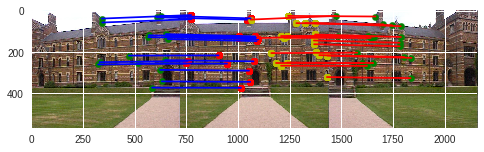

In [17]:
image = np.hstack((left_image,center_image,right_image))
width = left_image.shape[1]
plt.imshow(image)
for i in range(0,19):
  plt.plot([rand[i,0], rand2[i,0]+width], [rand[i,1],rand2[i,1] ],'b')
  plt.plot([rand_R[i,0]+2*width, rand2_R[i,0]+width], [rand_R[i,1],rand2_R[i,1] ],'r')
  plt.scatter(x=[rand[i,0]], y=[rand[i,1]], c='g', s=40)
  plt.scatter(x=[rand_R[i,0]+2*width], y=[rand_R[i,1]], c='g', s=40)
  plt.scatter(x=[rand2[:,0]+width], y=[rand2[:,1]], c='r', s=40)
  plt.scatter(x=[rand2_R[:,0]+width], y=[rand2_R[:,1]], c='y', s=40)



In [0]:
# Warping Left image with respect to Center, and Warping Right with respect to the Center

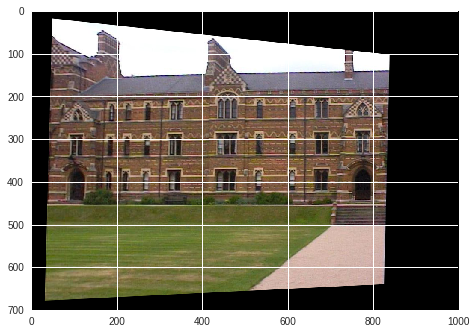

In [19]:
# Warping

im_out = cv2.warpPerspective(left_image,H_final,(1000,700))
plt.imshow(im_out)



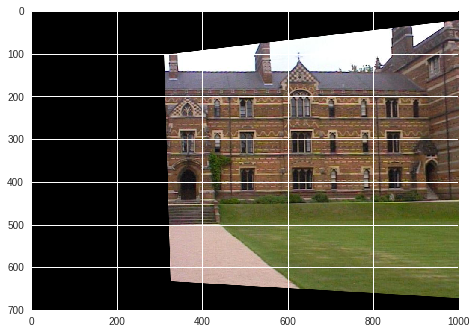

In [20]:
im_out2 = cv2.warpPerspective(right_image, (H_final_R), (1000,700))
plt.imshow(im_out2)

In [0]:
# Final Stitched / Mosaiced Image

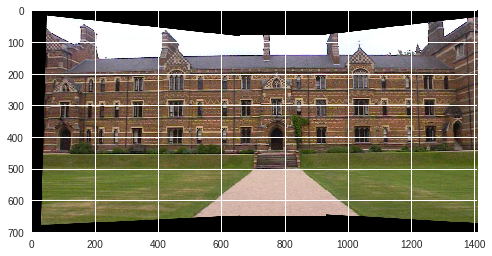

In [24]:

image2 = np.vstack((np.zeros((80,720,3)),center_image[:,:],np.zeros((80,720,3))))
image2 = image2.astype('uint8')
image= np.hstack((im_out[:700,:660],image2[:700,250:520],im_out2[:700,520:]))
plt.imshow(image)

In [0]:
# Image-Stitching implemented succesfully!